# CV Fold Preparation

This notebook prepare independant and balanced CV folds for full-disk flare forecast models.

We successively compute and store :  
-  windows labels and features   
   --> stored in F_PATH_WINDOWS, computed from flare catalog stored in PATH_FLCATALOG   
   --> computed in notebook cell 'Folds building > Raw Balanced Folds' 
     
-  chunks   
   --> stored in F_PATH_CHUNKS   
   --> computed in notebook cell 'Folds building > Raw Balanced Folds'  
     
-  maps of the optimal allocation of the chunks to the CV-fols   
   --> stored in F_PATH_ALLOC   
   --> computed in notebook cell 'Folds building > Raw Balanced Folds'  
     
-  climatological rates, used as composition targets for final validation folds   
   --> stored in PATH_CR_RATES   
   --> computed in notebook cell 'Folds building > Climmatological Rates'  
     
-  final training and validation folds  
   --> stored in F_PATH_FOLDS   
   --> computed in notebook cell 'Folds building > Final Folds'      
     
-  Operational test set   
   --> stored in F_PATH_TEST     
   --> computed in notebook cell 'Folds building > Final Folds'  
     

# Config

In [2]:
COLAB = False

if COLAB : 
  configSetup = {
      'COLAB'           : 'True',
      'PATH_ROOT_DRIVE' : '/content/drive/MyDrive/Projects/Forecast',
      'PATH_ROOT_LOCAL' : '/content/session',
      'PATH_SUNDL'      : '/content/sundl',
      'PATH_PROJECT'    : '/content/sundl/notebooks/flare_limits_pcnn'
  }
  !git clone https://github.com/gfrancisco20/sundl.git
  import sys
  import re
  sys.path.append(configSetup['PATH_SUNDL'])
  sys.path.append(configSetup['PATH_PROJECT'])
  configFile = f'{configSetup["PATH_PROJECT"]}/config.py'
  with open(configFile, 'r') as file:
    content = file.read()
  for constant in configSetup.keys():
    content = re.sub(re.compile(f'{constant} = .*'), f'{constant} = \'{configSetup[constant]}\'', content)
  with open(configFile, 'w') as file:
    file.write(content)
   
from config import *
from sundl.utils.colab import mountDrive
if COLAB:
  # mouting drive content in session on colab
  mountDrive()

# Libraries

In [5]:
from pathlib import Path
import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dill as pickle

from sundl.utils.data import read_Dataframe_With_Dates

# Folds building

## Raw Balanced Folds

In [6]:
%%time
from sundl.utils.flare.thresholds import mpfTresh, totehTresh
from sundl.utils.flare.windows import windowHistoryFromFlList
from sundl.utils.flare import flux2cls
from sundl.cv.temporal import buildChunks, instantiateFoldsSequentially

labelCols     = 'sw_v'                   # column name used to compute labels
testSplitDate = datetime.datetime(2019,1,1) # splitting date between CV and operational tes
buffer        = pd.DateOffset(days=4)      # size of discarded buffer between temporal chunks (ensure folds indepedancy)
chunk_width   = pd.DateOffset(days=20)      # size of temporal chunks
bufferTest    = pd.DateOffset(days=27)
bufferCme     = pd.DateOffset(days=4)  
n_fold        = 5                           # number of folds for CV
windows_avg_h = [1,6,12]

force_rebuild = True

minDate = pd.to_datetime('2010-05-13 00:00:00')
maxDate = pd.to_datetime('2023-04-19 00:00:00')
# if dataset unzipped, from 
# from sundl.utils.data import loadMinMaxDates
# minDate, maxDate = loadMinMaxDates(PATH_IMAGES)

timeserie_sw_folds = {}
dfsTest = {}

for window_h in windows_avg_h:

  chunkPath = F_PATH_CHUNKS_SW(chunk_width, buffer, window_h)
  foldsPath = F_PATH_FOLDS_SW(chunk_width, buffer, testSplitDate, window_h)
  testPath = F_PATH_TEST_SW(bufferTest, testSplitDate, window_h)
  
  swPath = F_PATH_SW_TS(window_h)

  print(minDate, maxDate)
  if foldsPath.exists() and not force_rebuild:
    chunks = read_Dataframe_With_Dates(chunkPath,['start','end'])
    dfTest[window_h] = pd.read_csv(testPath)
    with open(foldsPath, 'rb') as f1:
      timeserie_sw_folds[window_h] = pickle.load(f1)
  else:
    
    if swPath.exists():
      timeserie_sw = read_Dataframe_With_Dates(swPath,  minDate = minDate, maxDate = None)
    else:
      timeserie_sw = read_Dataframe_With_Dates(F_PATH_SW_TS(1),  minDate = minDate, maxDate = None)
      timeserie_sw = timeserie_sw[['sw_v']].rolling(f'{window_h}H', closed = 'right').mean()[int(window_h/2):]
    
    
    if foldsPath.exists():
      chunks = read_Dataframe_With_Dates(chunkPath,['start','end'])
    else:
      chunks = buildChunks(timeserie_sw,
                          chunk_width = chunk_width,
                          buffer      = buffer)
      
      chunks.to_csv(chunkPath)
      
    # Instantiate balanced folds 
    excludeDateRanges = [(date-bufferCme, date+bufferCme) for date in read_Dataframe_With_Dates(PATH_CMES).index]
    timeserie_sw_folds[window_h] , dfTest[window_h] = instantiateFoldsSequentially(
        chunks    = chunks,
        timeserie = timeserie_sw,
        n_folds = n_fold,
        testType  = 'temporal', #param [ 'folds', 'temporal' ] {type:"string"}
        testDate  = datetime.datetime(2019,1,1,0,0,0), # for temporal test split only,
        excludeDateRanges = excludeDateRanges
        )
    
    with open(foldsPath, 'wb') as f1:
      pickle.dump(timeserie_sw_folds[window_h] , f1)
    dfTest[window_h].to_csv(testPath)
    


            

TypeError: <lambda>() takes 2 positional arguments but 3 were given

### Plot

In [29]:
import numpy as np
foldsSize = pd.DataFrame({'count_train':np.zeros(len(timeserie_sw_folds)), 'count_val':np.zeros(len(timeserie_sw_folds))})
for k,trainVal in enumerate(timeserie_sw_folds):
  train,val = trainVal
  foldsSize.loc[k,'count_train'] = len(train)
  foldsSize.loc[k,'count_val'] = len(val)
foldsSize.index.rename('foldID',inplace=True)
foldsSize

,count_train,count_val
0,20781.0,5386.0
1,21139.0,5028.0
2,20968.0,5199.0
3,21023.0,5144.0
4,20757.0,5410.0


In [14]:
train

,Unnamed: 0,sw_v,sigma
timestamp,,,
2010-05-13 00:00:00,20687,376.0,7.0
2010-05-13 02:00:00,20689,389.0,8.0
2010-05-13 04:00:00,20691,447.0,6.0
2010-05-13 06:00:00,20693,452.0,10.0
2010-05-13 08:00:00,20695,488.0,9.0
...,...,...,...
2018-11-09 06:00:00,95141,429.0,5.0
2018-11-09 08:00:00,95143,429.0,10.0
2018-11-09 10:00:00,95145,461.0,8.0


In [11]:
buffer.days

4

In [10]:
int(buffer)

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'DateOffset'

Text(0, 0.5, 'fold ID')

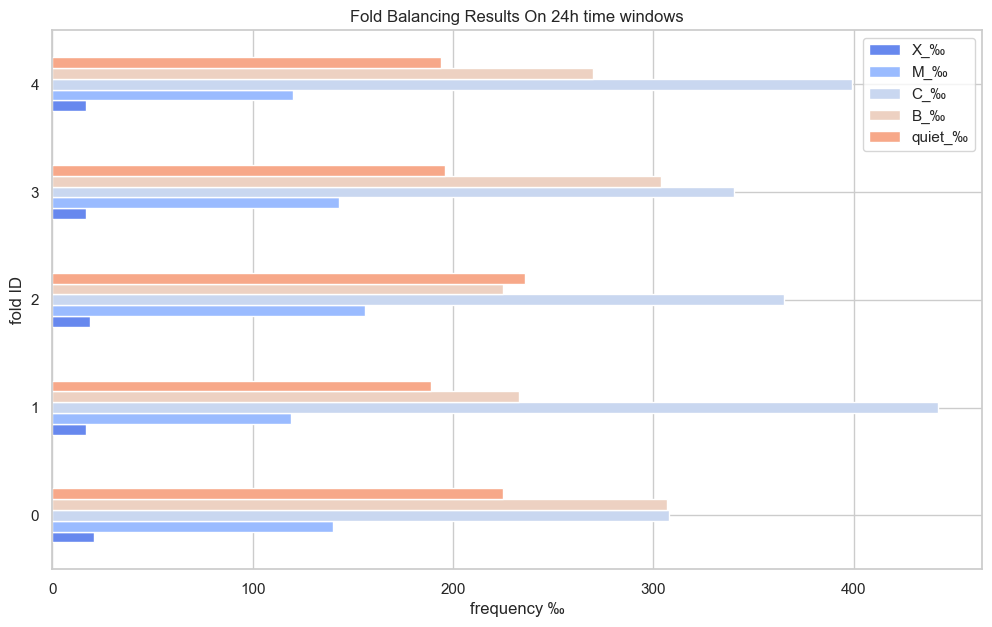

In [3]:
sns.set(style="whitegrid")
figsize=(12, 7)
plt.rcParams['font.size'] = 30

chunks2foldsAlloc['tot'] = chunks2foldsAlloc['X'] + chunks2foldsAlloc['M'] + chunks2foldsAlloc['C'] + chunks2foldsAlloc['B'] + chunks2foldsAlloc['quiet']
for cls in clsBalanceImportance.keys():
  chunks2foldsAlloc[cls+'_‰'] = np.round(1000 * chunks2foldsAlloc[cls] / chunks2foldsAlloc['tot'])

ax = chunks2foldsAlloc[['X_‰',	'M_‰',	'C_‰',	'B_‰',	'quiet_‰']].plot.barh(figsize=figsize,color = sns.color_palette('coolwarm'))
ax.set_title('Fold Balancing Results On 24h time windows')
ax.set_xlabel('frequency ‰')
ax.set_ylabel('fold ID')

# for foldID in  ax.get_yticks():
#   for i,cls in enumerate(classes):
#     y = foldID + 0.1*i - 0.25
#     val = folds.loc[foldID,cls]
#     ax.text(val + 2 ,y, f'{val:.0f}', size='small'

## Climatological Rates

In [4]:
%%time
from sundl.utils.flare import SCs # solar cycles dates

if Path(PATH_CR_RATES).exists():
  with open(PATH_CR_RATES, 'rb') as f1:
    climato_rates = pickle.load(f1)
else:
  climato_rates = {}
  for window_h in windowSizesH:
    climato_rates[window_h] = {'sc': [], 'class': [], 'cr_mpf':[], 'cr_toteh': []}
    windowsPath = F_PATH_WINDOWS('mpf', window_h)
    # fl_history = read_Dataframe_With_Dates(windowsPath)
    # All catalog needed
    fl_history = windowHistoryFromFlList(flCatalog, 
                                         window_h = window_h, 
                                         timeRes_h = 2, 
                                         minDate =  None, 
                                         maxDate = None
                                         )
    
    for cls in mpfTresh.keys():
      for sc in SCs.keys():
        start = SCs[sc][0]
        end = SCs[sc][1]
        df = fl_history.copy()
        if start is not None:
          df = df[df.index > start]
        if end is not None:
          df = df[df.index < end]
        n = len(df)
        mpf   = len(df[(df['mpf']   >= mpfTresh[cls][0] )            & (df['mpf'] < mpfTresh[cls][1] )]) / n * 100
        toteh = len(df[(df['toteh'] >= totehTresh[window_h][cls][0] )& (df['toteh'] < totehTresh[window_h][cls][1] )]) / n  * 100
        climato_rates[window_h]['sc'].append(sc)
        climato_rates[window_h]['class'].append(cls)
        climato_rates[window_h]['cr_mpf'].append(mpf)
        climato_rates[window_h]['cr_toteh'].append(toteh)
    climato_rates[window_h] = pd.DataFrame(climato_rates[window_h])
  with open(PATH_CR_RATES, 'wb') as f1:
    pickle.dump(climato_rates, f1)
climato_rates

CPU times: user 1.37 ms, sys: 1.82 ms, total: 3.18 ms
Wall time: 8.63 ms


{24:            sc  class     cr_mpf   cr_toteh
 0         all  quiet  20.165050  20.375825
 1          22  quiet  16.790811  16.823197
 2          23  quiet  20.732903  20.853142
 3          24  quiet  22.937604  23.438984
 4      peak24  quiet   6.031235   6.923201
 5   SC_25_Asc  quiet  23.963482  24.203734
 6         all      B  21.326715  22.261127
 7          22      B  19.375175  21.445689
 8          23      B  18.594499  20.057715
 9          24      B  26.584208  25.725014
 10     peak24      B  25.924972  22.646917
 11  SC_25_Asc      B  28.219385  28.452773
 12        all      C  35.592813  33.439064
 13         22      C  33.752186  28.052335
 14         23      C  36.898574  35.267023
 15         24      C  35.918277  36.768636
 16     peak24      C  47.486717  50.107873
 17  SC_25_Asc      C  34.411038  32.029105
 18        all      M  19.613053  20.091588
 19         22      M  25.139797  26.966341
 20         23      M  20.542370  20.638562
 21         24      M  12.85

## Final Folds (Undersampling)

### Computation

In [6]:
%%time
from sundl.cv.temporal import sampleFromFolds

# validation balance
crTag   = 'SC_25_Asc'
sizeVal = 2000
# training balance
clsBinsSizeTrain = {'quiet': 800, # final size *= (n_folds-1) 
                        'B': 800,
                        'C': 800,
                        'M': 800,
                        'X': 800}

for window_h in windowSizesH:
  for labelCol in labelCols:
    if labelCol == 'mpf':
      clsTresholds  = mpfTresh
    else:
      clsTresholds  = totehTresh[window_h]
      
  
  pathFoldsTrainVal = F_PATH_FOLDS(labelCol, window_h)
  pathTest = F_PATH_TEST(labelCol, window_h)
  
  if pathFoldsTrainVal.exists():
    with open(pathFoldsTrainVal, 'rb') as f1:
      dfFoldsTrainVal = pickle.load(f1)
    dfTest = read_Dataframe_With_Dates(pathTest)
  else:
    windowsPath = F_PATH_WINDOWS(labelCol, window_h)
    chunkPath = F_PATH_CHUNKS(labelCol, window_h)
    folldAllocPath = F_PATH_ALLOC(labelCol, window_h)
    
    # Folds instantitions
    fl_history = read_Dataframe_With_Dates(windowsPath)
    chunks = read_Dataframe_With_Dates(chunkPath,['start','end'])
    chunks2foldsAlloc = read_Dataframe_With_Dates(folldAllocPath)
    dfFolds, dfTest = instantiateFolds(fl_history, 
                                      chunks,
                                      chunks2foldsAlloc, 
                                      testSplitDate, 
                                      buffer,
                                      mpfTresh.keys(),
                                      verbose = 0
                                      )
    
    cr = climato_rates[window_h][climato_rates[window_h]['sc']==crTag][['class',f'cr_{labelCol}']].set_index('class')
    clsBinsSizeVal = {cls : int(round(sizeVal*cr.loc[cls].values[0]/100)) for cls in clsBinsSizeTrain.keys()}

    print('\n\nFINAL Training FOLDS : \n')
    dfFoldsBalanced = sampleFromFolds(dfFolds,  balance  = True, clsBinsSize = clsBinsSizeTrain)
    print('\n\nFINAL Validation FOLDS : \n')
    dfFoldsClimatological = sampleFromFolds(dfFolds, balance  = True, clsBinsSize = clsBinsSizeVal)
    
    dfFoldsTrainVal = [] #= [(dfTrain, dfVal)]
    for k in dfFolds.keys():
      dfVal = dfFoldsClimatological[k]
      trainIdxs = list(dfFolds.keys())
      trainIdxs.remove(k)
      for i,trainIdx in enumerate(trainIdxs):
        if i==0:
          dfTrain = dfFoldsBalanced[trainIdx]
        else:
          dfTrain = pd.concat([dfTrain,dfFoldsBalanced[trainIdx]],axis=0)
      dfFoldsTrainVal.append((dfTrain, dfVal))
    with open(pathFoldsTrainVal, 'wb') as f1:
      pickle.dump(dfFoldsTrainVal, f1)
    dfTest.to_csv(pathTest)


FOLD 0:

FOLD 1:

FOLD 2:

FOLD 3:

FOLD 4:


FINAL Training FOLDS : 


FOLD 0: 3323
quiet-flares samples: 800 (24.07%)
B-flares samples: 800 (24.07%)
C-flares samples: 800 (24.07%)
M-flares samples: 800 (24.07%)
X-flares samples: 123 (3.70%)

FOLD 1: 3318
quiet-flares samples: 800 (24.11%)
B-flares samples: 800 (24.11%)
C-flares samples: 800 (24.11%)
M-flares samples: 800 (24.11%)
X-flares samples: 118 (3.56%)

FOLD 2: 3308
quiet-flares samples: 800 (24.18%)
B-flares samples: 800 (24.18%)
C-flares samples: 800 (24.18%)
M-flares samples: 800 (24.18%)
X-flares samples: 108 (3.26%)

FOLD 3: 3310
quiet-flares samples: 800 (24.17%)
B-flares samples: 800 (24.17%)
C-flares samples: 800 (24.17%)
M-flares samples: 800 (24.17%)
X-flares samples: 110 (3.32%)

FOLD 4: 3313
quiet-flares samples: 800 (24.15%)
B-flares samples: 800 (24.15%)
C-flares samples: 800 (24.15%)
M-flares samples: 800 (24.15%)
X-flares samples: 113 (3.41%)


FINAL Validation FOLDS : 


FOLD 0: 1999
quiet-flares samples: 479

### Plot

In [13]:
from sundl.utils.flare import class_stats
train = pd.DataFrame(dict(**{'foldID' : np.arange(len(dfFoldsTrainVal))},
                          **{cls : np.zeros(len(dfFoldsTrainVal)) for cls in clsBalanceImportance.keys()})
                    )
val = train.copy()

for idx,(dfTrain, dfVal) in enumerate(dfFoldsTrainVal):
  train.loc[idx,mpfTresh.keys()] = class_stats(dfTrain, colIdCls = 'cls', classes = list(mpfTresh.keys()))[mpfTresh.keys()].sum()
  val.loc[idx,mpfTresh.keys()] = class_stats(dfVal, colIdCls = 'cls', classes = list(mpfTresh.keys()))[mpfTresh.keys()].sum()
train

13249
13254
13264
13262
13259


,foldID,X,M,C,B,quiet
0,0,449.0,3200.0,3200.0,3200.0,3200.0
1,1,454.0,3200.0,3200.0,3200.0,3200.0
2,2,464.0,3200.0,3200.0,3200.0,3200.0
3,3,462.0,3200.0,3200.0,3200.0,3200.0
4,4,459.0,3200.0,3200.0,3200.0,3200.0


#### Training

Text(0.5, 1.0, 'Final Trainin Folds')

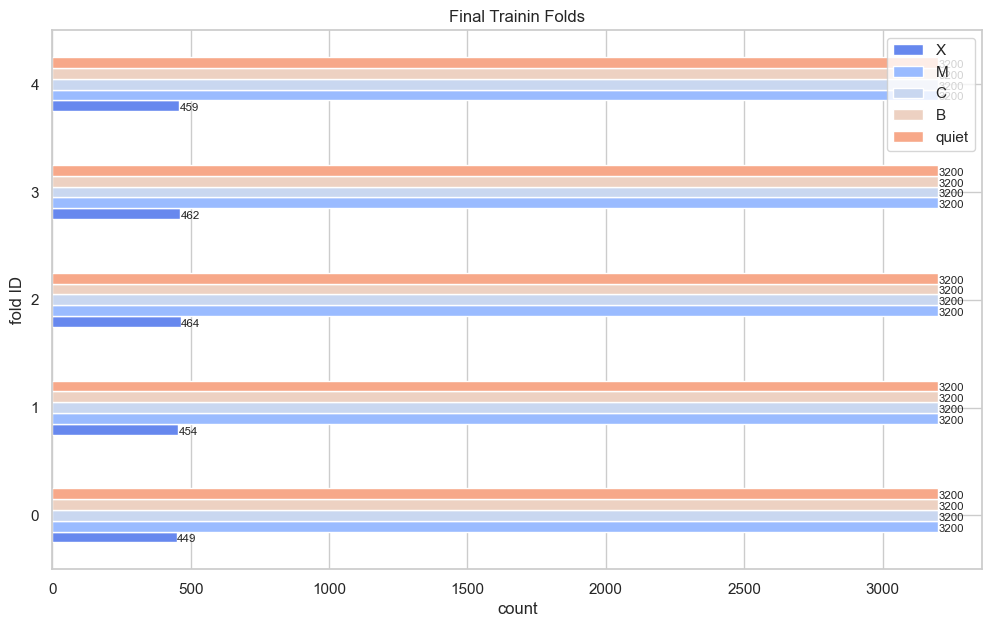

In [14]:
tmp = train.copy()
sns.set(style="whitegrid")
figsize=(12, 7)
classes = ['X','M','C','B','quiet']
ax = tmp[classes].plot.barh(figsize=figsize,color = sns.color_palette('coolwarm'))

ax.set_xlabel('count')
ax.set_ylabel('fold ID')

for foldID in  ax.get_yticks():
  for i,cls in enumerate(classes):
    y = foldID + 0.1*i - 0.25
    value = tmp.loc[foldID,cls]
    ax.text(value + 2 ,y, f'{value:.0f}', size='x-small')

plt.rcParams['font.size'] = 30

ax.set_title('Final Trainin Folds')

#### Validation

Text(0.5, 1.0, 'Final Trainin Folds')

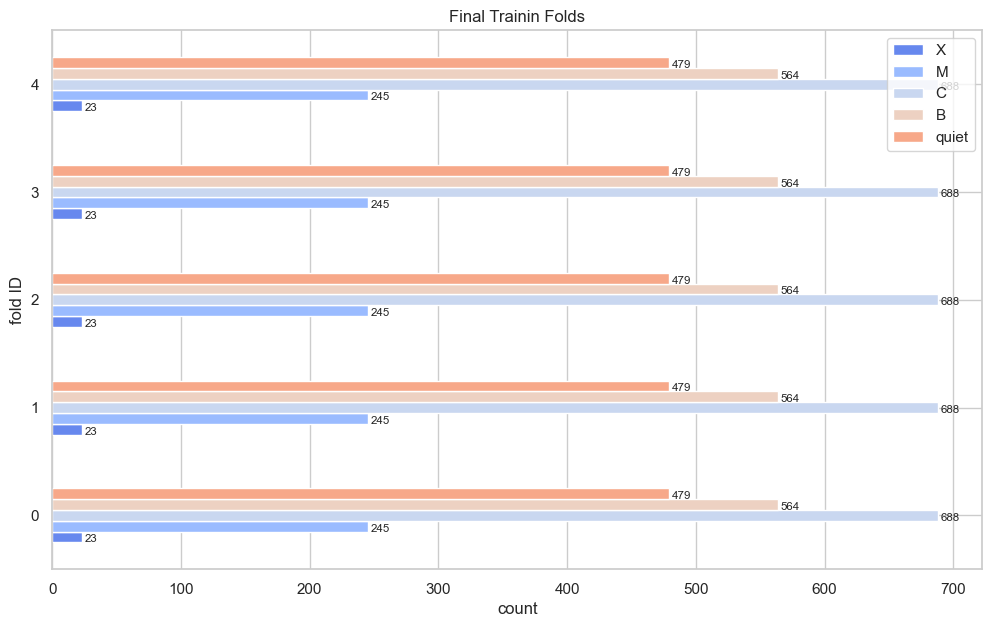

In [15]:
tmp = val.copy()
sns.set(style="whitegrid")
figsize=(12, 7)
classes = ['X','M','C','B','quiet']
ax = tmp[classes].plot.barh(figsize=figsize,color = sns.color_palette('coolwarm'))

ax.set_xlabel('count')
ax.set_ylabel('fold ID')

for foldID in  ax.get_yticks():
  for i,cls in enumerate(classes):
    y = foldID + 0.1*i - 0.25
    value = tmp.loc[foldID,cls]
    ax.text(value + 2 ,y, f'{value:.0f}', size='x-small')

plt.rcParams['font.size'] = 30

ax.set_title('Final Trainin Folds')